In [152]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

import seaborn as sns
import matplotlib.pyplot as plt

In [153]:
from src.manager import DbManager

dbm = DbManager('../data/vast.db')
dbm.connect()

In [154]:
ts_idx = dbm.table_to_df('ts_idx').timestamp
ts_idx.diff().describe()

count    2851.000000
mean       55.715889
std         9.041190
min        21.000000
25%        53.000000
50%        54.000000
75%        56.000000
max       161.000000
Name: timestamp, dtype: float64

C:\Users\ergot\mambaforge\envs\ml\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\ergot\mambaforge\envs\ml\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


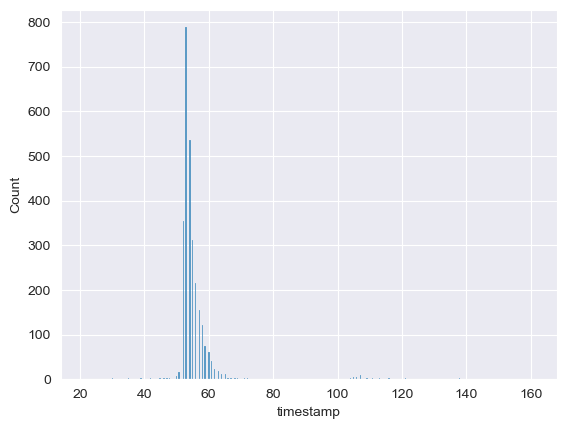

In [155]:
sns.histplot(ts_idx.diff());

In [156]:
cost = dbm.table_to_df('cost_ts').set_index('machine_id')




In [157]:
df = cost[['dph_base', 'timestamp']]
df = df.loc[14096]
mask = df.dph_base.shift() != df.dph_base
df.loc[mask]

,dph_base,timestamp
machine_id,,
14096,440,1697699070


In [158]:
df = pd.DataFrame({'dph_base': [100, 100 , 200, 200, 250, 200], 
                   'timestamp': [1, 2, 3, 1, 2, 3]},
                  # columns=['dph_base', 'timestamp'],
                  index=[32, 32, 32, 120, 120, 120])
df.index.name = 'machine_id'
df

,dph_base,timestamp
machine_id,,
32,100,1
32,100,2
32,200,3
120,200,1
120,250,2
120,200,3


In [159]:
def drop_dph_duplicates(df_):
    return df_.loc[df_.dph_base.shift() != df_.dph_base]

In [160]:
df.groupby('machine_id').apply(drop_dph_duplicates).reset_index(level=0, drop=True)

,dph_base,timestamp
machine_id,,
32,100,1
32,200,3
120,200,1
120,250,2
120,200,3


In [161]:
cost = cost[['dph_base', 'timestamp']].groupby('machine_id').apply(drop_dph_duplicates).reset_index(level=0, drop=True)
cost

,dph_base,timestamp
machine_id,,
63,1000,1697699070
162,600,1697699070
274,440,1697699070
275,440,1697699070
283,330,1697699070
...,...,...
14385,440,1697852228
14386,2800,1697854838
14388,200,1697848348


In [162]:
rent = dbm.table_to_df('rent_ts').set_index('machine_id')
rent_count = rent.groupby('machine_id')['timestamp'].count().sort_values(ascending=False)
rent_count

machine_id
13785    844
6160     571
11038    401
7135     189
9459     155
        ... 
13141      1
13143      1
13148      1
13150      1
14389      1
Name: timestamp, Length: 2037, dtype: int64

In [163]:
cost_count = cost.dph_base.groupby('machine_id').count().sort_values(ascending=False)
cost_count

machine_id
3056     234
3059     234
8960     233
8298     217
4383     117
        ... 
8297       1
11864      1
8308       1
11862      1
63         1
Name: dph_base, Length: 2037, dtype: int64

In [164]:
set(rent_count[rent_count > 15].index) & set(cost_count[cost_count > 15].index)

{3056, 3059, 4383, 4384, 8298, 8960, 11851, 12167, 13641, 14316}

In [165]:
mach_id = 8506
gpus_rented = rent.loc[[mach_id]].set_index('timestamp').num_gpus_rented
gpus_rented

timestamp
1697699070    4
Name: num_gpus_rented, dtype: int64

In [166]:
costs = cost.loc[[mach_id]].set_index('timestamp', drop=True)
costs

,dph_base
timestamp,
1697699070,2200


In [167]:
df = pd.concat([gpus_rented, costs], axis=1)
df

,num_gpus_rented,dph_base
timestamp,,
1697699070,4,2200


In [168]:
df.ffill(inplace=True)
df

,num_gpus_rented,dph_base
timestamp,,
1697699070,4,2200


In [169]:
df[:-1]

,num_gpus_rented,dph_base
timestamp,,
1697699070,4,2200


In [146]:
df.index.diff()[1:]

Index([], dtype='float64', name='timestamp')

In [147]:
duration = df.index.diff()[1:]
df = df[:-1].copy()
df['duration'] = duration
df

,num_gpus_rented,dph_base,duration
timestamp,,,


In [149]:
num_gpus = 4
(df.num_gpus_rented / num_gpus * df.dph_base / 1000 * df.duration / 3600).sum()

0.0

In [ ]:
dbm.close()